# K-Means

## Table of Contents

- [Theory](#theory)
    - [Creating a sample dataset](#creating-a-sample-dataset)
    - [Why should we perform EDA first?](#why-should-we-perform-eda-first?)
    - [Mins and Maxs](#mins-and-maxs)
    - [Mean and Standard Deviation](#mean-and-standard-deviation)
    - [Missing Values](#missing-values)
    - [Visualizing the dataset](#visualizing-the-dataset)

K-Means is a staple of unsupervised learning.<br>
Understanding how K-Means works is essential to understanding how more advanced clustering algorithms and unsupervised learning in general work.<br>
It is also a good way to catch the basics on how to use the `sklearn` library.<br>

This is the first in a series of articles on Machine Learning algorithms. Layed out in a way that is easy to understand and follow.

In [158]:
# All the necessary imports
import numpy as np
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt

## Theory

K-Means is a simple clustering algorithm that can be used to find $k$ many groups within a dataset.<br>
Sources are unsure about the exact origin of the algorithm, but it is believed to have been developed by Stuart Lloyd in 1957 and published later by James MacQueen in 1967.

The core characteristic making K-Means so versatile is that it works without any prior or additional knowledge added to the dataset.<br>
With supervised learning, additional knowledge would be added to the dataset in the form of labels, which would denote the group that a data point belongs to beforehand.

K-Means belongs to the unsupervised learning category of Machine Learning algorithms.<br>
With unsupervised learning, we don't have the luxury of labels. We have to find a way to group the data based on its features alone.

> K-Means aims at finding groups within a dataset.<br>
> It does not rely on any additional information, making it an unsupervised clustering algorithm.

How does this work?<br>
For a theoretical approach, we will look at a very bare-bones example. Don't worry, this will be expanded upon later.

### Creating a sample dataset

In order to explain K-Means, we will have to see its intentions in action.<br>
To do that, we create a sample dataset that we can work with.<br>
We will create this dataset and pre-determine it to contain 4 clusters.<br>
From that, we will be able to most clearly follow the K-Means algorithm.

In [172]:
# Seed for reproducibility
np.random.seed(4)

n_samples = 100 # Number of data points
n_features = 2  # Each data point has 2 features
n_clusters = 4  # The dataset will contain 4 clusters

# Generate 100 data points, 2 dimensions, value range: 0-99 (inclusive), forming n_clusters many clusters
X, _ = datasets.make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters+1)

# Randomly delete 5% of the data points for each feature to mimic the real-world scenario where data points are not always complete
missing_pct = 0.05 # 5% of the data points should be deleted
missing_idx = np.random.randint(0, n_samples, size=(int(100 * missing_pct), n_features)) # These are the (5, 2) indices of the data points to be deleted

# Set the randomly selected data points to NaN
X[missing_idx[:,0], 0] = np.nan
X[missing_idx[:,1], 1] = np.nan

print(f'First 5 of the {n_samples} data points, each being {n_features}-dimensional:\n {X[:5]}\n')

First 5 of the 100 data points, each being 2-dimensional:
 [[ 10.72550582   3.64867534]
 [         nan   6.28640289]
 [ 11.42846765   1.85948594]
 [  9.2343933  -10.76637063]
 [  7.99313649   0.93528488]]



Before applying K-Means head-on to any dataset, we should explore the dataset itself first.<br>
Very fittingly, this process is named **Exploratory Data Analysis** (EDA).

### Why should we perform EDA first?

Through EDA, we can gain insights into the data and ensure the suitability of the algorithm.

EDA allows for a better understanding of the data's characteristics, distribution, and potential challenges.<br>
It helps identify outliers, assess data quality, and determine appropriate steps for data preprocessing.<br>
By exploring the data, one can make informed decisions about feature selection, scaling, or handling missing values.

For our tiny example, we can perform the following things:
- Determine minimum and maximum values
- Determine the mean and standard deviation
- Find and address missing values (we will replace them with the mean)
- Visualize the now preprocessed dataset
- Find a most likely optimal number of clusters

> EDA is quite the important step in the Machine Learning process. Skipping it can lead to really bad results. And nobody wants that.

### Mins and Maxs

The maxmimum and minimum per each feature tell us the range of values that we can expect.<br>
We calculate them in order to determine the range of values that we can expect per feature.<br>
This in turn will come in handy when we scale and/or normalize the data to reduce the impact of individual outliers later on.

In [173]:
# Determine minimum and maximum values for each feature
mins = np.nanmin(X, axis=0)
maxs = np.nanmax(X, axis=0)

print(f'Minimums per feature (excluding NaNs): {mins}')
print(f'Maximums per feature (excluding NaNs): {maxs}\n')

Minimums per feature (excluding NaNs): [ -5.86743495 -11.04368518]
Maximums per feature (excluding NaNs): [11.93027136  6.31872494]



### Mean and Standard Deviation

The mean and standard deviation per each feature tell us about the feature's distribution within its [min, max] bounds.<br>
By examining the mean, we can determine the typical value for a feature.

The standard deviation measures the dispersion or spread of the data around the mean.<br>
The higher the standard deviation, the greater the spread of values and the more inhomogeneous the data.

By comparing individual data points to the mean and considering the standard deviation,<br>
it becomes easier to detect extreme values that may require further investigation.

In [178]:
# Determine mean and standard deviation for each feature
means = np.nanmean(X, axis=0)
stds = np.nanstd(X, axis=0)

print(f'Means per feature (excluding NaNs): {means}')
print(f'Standard deviations per feature (excluding NaNs): {stds}\n')

Means per feature (excluding NaNs): [ 5.50660515 -2.3538705 ]
Standard deviations per feature (excluding NaNs): [5.58150185 4.92693667]



### Missing Values

We want to use as much of the data as possible.<br>
The problem is that there are `NaN` values in the dataset, affecting accuracy and reliability of the model and potentially introducing a bias.<br>

> Ignoring missing values without appropriate handling can lead to biased, unfair or plain wrong outcomes, especially if the missingness is not random but systematic, which we can't know for sure.<br>
> By addressing missing values, we mitigate this risk.

In our case, it is sufficient to replace the missing values with the mean of the respective feature.<br>
This preserves the distribution of the data and does not introduce any bias. It is also a very simple and well established approach.

In [189]:
# Check if there are any NaNs in the data and if so, how many
print(f'Number of NaNs per feature: {np.sum(np.isnan(X), axis=0)}')

# Replace NaNs of both features with the corresponding mean
X[np.isnan(X[:, 0]), 0] = means[0]
X[np.isnan(X[:, 1]), 1] = means[1]

# Just for sanity checking
print(f'Number of NaNs per feature after fixing: {np.sum(np.isnan(X), axis=0)}')

Number of NaNs per feature: [0 0]
Number of NaNs per feature after fixing: [0 0]


### Visualizing the dataset

Visualizing the dataset is a good way to get a feel for the data. It's an art form in itself.<br>
Below, we produce two graphs. The left one shows the data points as they are now, including the theoretical mean point.<br>
We color each point based on whether it is above or below the standard deviation of the first and second feature.

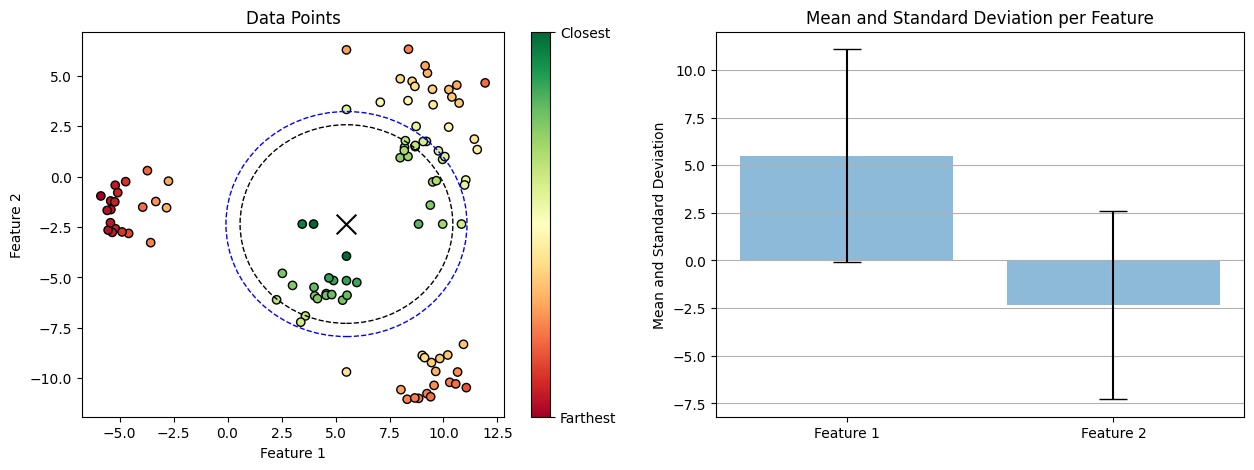

In [231]:
# We want to color the data points based on their distance to the mean
distances = np.linalg.norm(X - means, axis=1)
normalized_distances = -((distances - distances.min()) / (distances.max() - distances.min()))
cmap = plt.cm.RdYlGn # Color map for mapping normalized distances to colors

# Plot two graphs in one figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Visualize the data points
ax1.scatter(X[:, 0], X[:, 1], marker='o', c=normalized_distances, cmap=cmap, edgecolors='k')
# Plot the mean point
ax1.scatter(means[0], means[1], marker='x', c='black', s=200)
# Plot the standard deviation circle
ax1.add_artist(plt.Circle(means, stds[0], color='blue', fill=False, linestyle='--'))
ax1.add_artist(plt.Circle(means, stds[1], color='black', fill=False, linestyle='--'))

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Data Points')

# Add colorbar to ax1
cbar = fig.colorbar(ax1.collections[0], ax=ax1)
cbar.set_ticks([0, -1])
cbar.set_ticklabels(['Closest', 'Farthest'])

# Plot the mean and standard deviation for each feature
ax2.bar(np.arange(n_features), means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax2.set_ylabel('Mean and Standard Deviation')
ax2.set_xticks(np.arange(n_features))
ax2.set_xticklabels(['Feature 1', 'Feature 2'])
ax2.set_title('Mean and Standard Deviation per Feature')
ax2.yaxis.grid(True)

If we would stop here, the red points are the ones that we would expect to be outliers.<br>
But we can do better and account for the clusters that we know are in the dataset.

Let's finally apply K-Means.

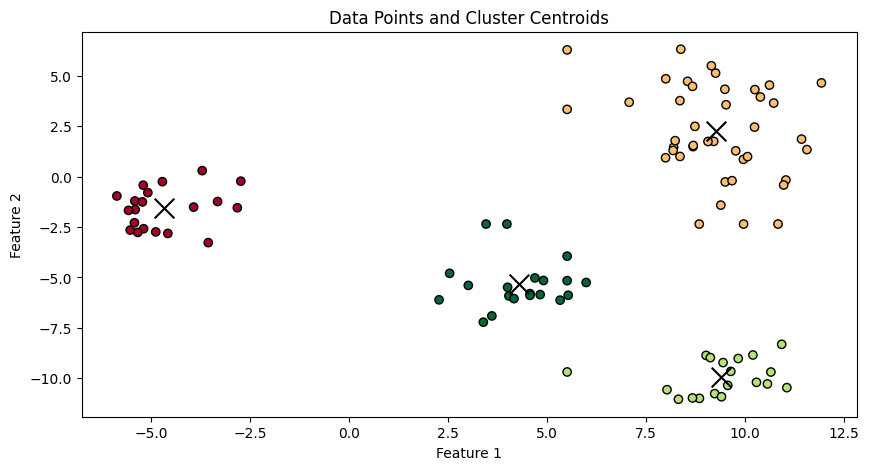

In [238]:
# Run K-Means on the dataset X
kmeans = KMeans(n_init=1, n_clusters=n_clusters, random_state=4).fit(X)

# Plot the data points and the cluster centroids
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=kmeans.labels_, cmap=cmap, edgecolors='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', c='black', s=200)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Points and Cluster Centroids');

Text(0.5, 1.0, 'Data Points and Cluster Centroids')

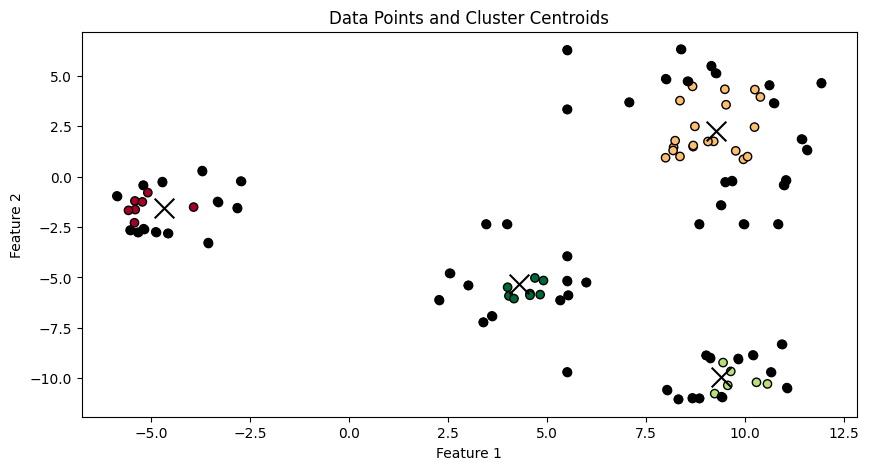

In [243]:
# Calculate the standard deviation for each cluster
std_deviations = []
for i in range(n_clusters):
    cluster_points = X[kmeans.labels_ == i]
    std_dev = np.std(cluster_points, axis=0)
    std_deviations.append(std_dev)

# Determine the points falling outside the cluster's standard deviation
outlier_indices = []
for i, point in enumerate(X):
    cluster_label = kmeans.labels_[i]
    cluster_std_dev = std_deviations[cluster_label]
    if np.any(np.abs(point - kmeans.cluster_centers_[cluster_label]) > cluster_std_dev):
        outlier_indices.append(i)

# Plot the data points and the cluster centroids, painting outliers black
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=kmeans.labels_, cmap=cmap, edgecolors='k')
plt.scatter(X[outlier_indices, 0], X[outlier_indices, 1], marker='o', c='black', edgecolors='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', c='black', s=200)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Points and Cluster Centroids')